### 1. Overview & data choice for healthy vs aged classification

For this notebook I originally planned to use the **NASA PCoE Li-ion Battery Aging Datasets**  
(<https://data.nasa.gov/dataset/li-ion-battery-aging-datasets>), which contain full aging
trajectories down to clear **end-of-life (EoL)** and are widely used for **SoH / RUL**
studies. At the time of this work I could not access that dataset, so I instead reuse the
SoH-from-EIS dataset from  
[**02 – SoH from EIS (Rashid et al.)**](./02_SoH_from_EIS.ipynb) as a **stand-in** to
demonstrate a simple healthy vs aged **classification workflow**.

In real applications, a cell is typically considered to have reached EoL when its capacity
(or SoH) drops to around **80%** of nominal. The Rashid SoH-from-EIS dataset I use here
only covers SoH levels from **100% down to 80%** in 5% steps, and does **not** include
cells degraded below 80% like the NASA PCoE data would. To still illustrate a binary
screening task with the data at hand, I define:

- `healthy` = SoH ≥ 90%  
- `aged`    = SoH < 90%

This threshold is therefore **chosen for demonstration**, not as a universal definition
of EoL, and should be interpreted as “early screening for cells that have started to age”
rather than a hard safety or warranty limit. In practice, I would expect cells aged
**below 80% SoH to develop a noticeably different impedance fingerprint/signature** from
the SoH ranges considered here (SoH ≥ 90% and SoH < 90%), which could **substantially
change** both the models and the conclusions. The current notebook should therefore be
read as a **workflow demonstration** under limited data, not as a definitive analysis of
fully aged cells.

---

### 2. Dataset and feature pipeline (from 02 – SoH from EIS)

As in  
[**02 – SoH from EIS (Rashid et al.)**](./02_SoH_from_EIS.ipynb), I use the public dataset:

> Rashid, Muhammad; Faraji-Niri, Mona; Sansom, Jonathan; Sheikh, Muhammad;  
> Widanage, Dhammika; Marco, James (2023),  
> **“Dataset for rapid state of health estimation of lithium batteries using EIS and machine learning: Training and validation”**,  
> *Data in Brief*, 48, 109157, doi: 10.1016/j.dib.2023.109157.  
> Original data: **“DIB_Data”**, Mendeley Data, V3, doi: 10.17632/mn9fb7xdx6.3 (CC0 1.0).

Dataset highlights (same as in 02 – SoH from EIS):

- **25 cylindrical Li-ion cells**, aged from SoH 100% down to 80% in 5% steps  
  (100, 95, 90, 85, 80%).
- At each SoH stage, reference performance tests (capacity / SoH) plus **electrochemical
  impedance spectroscopy (EIS)** at multiple **SOC** and **temperature** conditions.
- Designed specifically to study **fast SoH estimation from EIS with machine learning**.

In this notebook I **reuse the same data loading, cleaning and feature engineering
pipeline** as in 02 – SoH from EIS:

- I load the raw EIS spectra and associated metadata,
- perform the same basic QC and filtering,
- and construct the same engineered impedance feature table (ohmic / low-frequency
  resistances, summary |Z| and phase statistics, and sampled spectral points).

For details of the data preparation steps, please refer to  
[**02 – SoH from EIS (Rashid et al.)**](./02_SoH_from_EIS.ipynb). Here I start directly
from the prepared feature table and focus on the **binary classification** of `healthy`
vs `aged` cells based on those impedance features.


### 2.1 Load EIS data

In [1]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd

# Deterministically add ../ (repo root) so that ../src is on the module path
repo_root = Path("..").resolve()
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from src.utils import load_and_process_dib_eis, build_impedance_feature_table

# Load long-format EIS data
eis_long_df = load_and_process_dib_eis()

# One row per unique EIS test (cell, SoH, T, SOC)
tests_df = (
    eis_long_df
    .groupby(["cell_id", "soh_pct", "temp_c", "soc_pct"], as_index=False)
    .agg(
        n_points=("frequency_hz", "size"),
        n_freq=("frequency_hz", "nunique"),
    )
)

n_cells = tests_df["cell_id"].nunique()
n_tests = len(tests_df)

soh_levels = sorted(tests_df["soh_pct"].unique())
soc_levels = sorted(tests_df["soc_pct"].unique())
temp_levels = sorted(tests_df["temp_c"].unique())

if tests_df["n_freq"].nunique() == 1:
    freq_points_per_spectrum = int(tests_df["n_freq"].iloc[0])
else:
    freq_points_per_spectrum = f"{tests_df['n_freq'].min()}–{tests_df['n_freq'].max()}"

summary_table = pd.DataFrame(
    {
        "n_cells": [n_cells],
        "n_eis_tests": [n_tests],
        "soh_levels": [", ".join(str(x) for x in soh_levels)],
        "soc_levels": [", ".join(str(x) for x in soc_levels)],
        "temp_levels": [", ".join(str(x) for x in temp_levels)],
        "freq_points_per_spectrum": [freq_points_per_spectrum],
    }
)

summary_table

,n_cells,n_eis_tests,soh_levels,soc_levels,temp_levels,freq_points_per_spectrum
0,24,360,"80, 85, 90, 95, 100","5, 20, 50, 70, 95","15, 25, 35",61


### 2.2 Build the impedance feature table for ML


In [2]:
# Build the engineered impedance feature table (one row per EIS test)
features_df = build_impedance_feature_table(eis_long_df)

print(f"Feature table shape: {features_df.shape}")
features_df.head()


Feature table shape: (360, 27)


,cell_id,soh_pct,temp_c,soc_pct,R_hf_ohm,R_lf_ohm,delta_R_ohm,Zmag_mean,Zmag_std,Zmag_min,...,Zmag_f1p0,phase_f1p0,Zmag_f10p0,phase_f10p0,Zmag_f100p0,phase_f100p0,Zmag_f1000p0,phase_f1000p0,Zmag_f10000p0,phase_f10000p0
0,2,95,15,5,0.02995,0.07366,0.04371,0.040826,0.016416,0.024201,...,0.042847,-0.282403,0.031430,-0.123542,0.027523,-0.077613,0.024205,0.097449,0.043538,0.812199
1,2,95,15,20,0.03001,0.07916,0.04915,0.041919,0.018060,0.024285,...,0.042731,-0.290515,0.031688,-0.122719,0.027668,-0.079707,0.024291,0.095818,0.043579,0.811200
2,2,95,15,50,0.02965,0.03573,0.00608,0.029907,0.003850,0.023819,...,0.030956,-0.031686,0.029673,-0.047501,0.026807,-0.059273,0.023819,0.103972,0.043398,0.818643
3,2,95,15,70,0.02960,0.03803,0.00843,0.030187,0.004274,0.023747,...,0.030942,-0.037886,0.029639,-0.051610,0.026685,-0.058380,0.023747,0.103440,0.043320,0.818540
4,2,95,15,95,0.02958,0.04171,0.01213,0.031920,0.005565,0.023771,...,0.034760,-0.067860,0.030048,-0.092483,0.026772,-0.062605,0.023772,0.101259,0.043262,0.817930


## 3. SoH-based labels for healthy vs aged classification

In this section I convert the SoH information into a **binary health label** that will be
used as the target for the classifier:

- `healthy` = SoH ≥ 90%  
- `aged`    = SoH < 90%

I first add a continuous SoH fraction (`soh_frac`) and then derive the binary
`health_label` (and a numeric `target_aged` = 1 for aged, 0 for healthy). I also inspect
the resulting **class balance** (counts and percentages) to see how many samples fall
into each group before training any models.


### 3.1 Define SoH-based binary labels

In [3]:
# Work on a copy to keep the original feature table intact
data = features_df.copy()

# SoH as fraction (0–1), derived from the integer percentage
data["soh_frac"] = data["soh_pct"] / 100.0

# Binary labels:
# - healthy = SoH ≥ 90%
# - aged    = SoH < 90%
data["health_label"] = np.where(data["soh_pct"] >= 90, "healthy", "aged")

# (Optional) numeric target for later ML models: 1 = aged, 0 = healthy
data["target_aged"] = (data["health_label"] == "aged").astype(int)

data[["cell_id", "soh_pct", "temp_c", "soc_pct", "health_label"]].head()


,cell_id,soh_pct,temp_c,soc_pct,health_label
0,2,95,15,5,healthy
1,2,95,15,20,healthy
2,2,95,15,50,healthy
3,2,95,15,70,healthy
4,2,95,15,95,healthy


### 3.2 Inspect healthy vs aged class balance


In [4]:
# Count samples per class
label_counts = (
    data["health_label"]
    .value_counts()
    .rename_axis("health_label")
    .reset_index(name="n_samples")
)

# Add percentages
total = label_counts["n_samples"].sum()
label_counts["pct"] = (label_counts["n_samples"] / total * 100).round(1)

label_counts


,health_label,n_samples,pct
0,healthy,210,58.3
1,aged,150,41.7


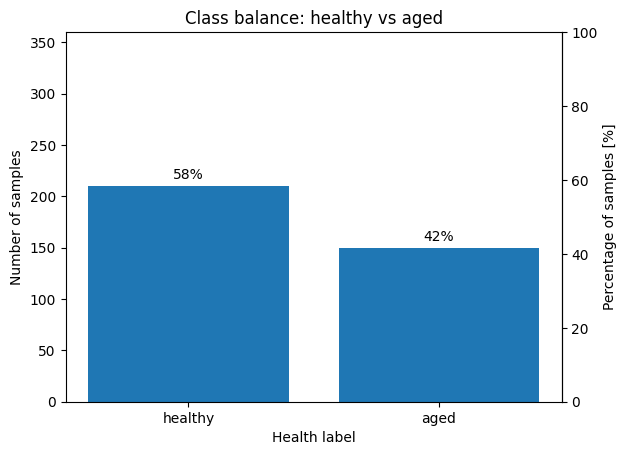

In [9]:
import matplotlib.pyplot as plt

# We already have label_counts with columns: health_label, n_samples, pct
total = label_counts["n_samples"].sum()

fig, ax1 = plt.subplots()

# Primary axis: counts
bars = ax1.bar(label_counts["health_label"], label_counts["n_samples"])
ax1.set_xlabel("Health label")
ax1.set_ylabel("Number of samples")
ax1.set_title("Class balance: healthy vs aged")
ax1.set_ylim(0, total)

# Percentage labels using built-in bar_label
pct_labels = [f"{p:.0f}%" for p in label_counts["pct"]]
ax1.bar_label(bars, labels=pct_labels, padding=3)

# Secondary axis: percentages, linked to counts
def counts_to_pct(c):
    return 100 * c / total

def pct_to_counts(p):
    return total * p / 100

ax2 = ax1.secondary_yaxis("right", functions=(counts_to_pct, pct_to_counts))
ax2.set_ylabel("Percentage of samples [%]")
ax2.set_ylim(0, 100)

plt.show()
